In [2]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
from postprocessing.rate_maps import bin_pos_data_axona, make_rate_maps, plot_cluster_across_sessions, speed_filter_spikes
import pandas as pd
import matplotlib.pyplot as plt
from ephys_utils import select_spikes_by_trial, transform_spike_data
from spatial_information import spatial_info
from spatial_significance import spatial_significance

data_path = '/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data'

calculate_significance = True
plot_rate_maps = True

place_cells = 0

# Load pickled data
if "df_all_cells" not in locals():
    df_all_cells = pd.read_pickle(f'{data_path}/df_all_cells.pkl') 
    # Drop rows with no included clusters
    df_all_cells = df_all_cells.dropna()
    print(f'{len(df_all_cells.index)} sessions retained')

spatial_info_all = pd.DataFrame(columns = ['bits_per_spike', 'bits_per_sec', 'p_value', 'z_score' 'age'], dtype = 'object')
rates_all = pd.DataFrame(columns = ['mean_rates', 'max_rates', 'age'], dtype = 'object')
rate_maps_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')
pos_maps_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')
spike_times_all = pd.DataFrame(columns = ['open-field_1', 'open-field_2', 't-maze_1', 't-maze_2', 'age'], dtype = 'object')

# Calculate rate maps
for session, obj in df_all_cells['ephys_object'].items():
    
    # Loop through trials and generate rate maps
    rate_maps = {}
    raw_rate_maps = {}
    pos_map = {}
    max_rates = {}
    mean_rates = {}
    bits_per_spike = {}
    bits_per_sec = {}
    spike_times = {}
    p_values = {}
    z_scores = {}
    
    # Make rate maps for all trials
    for trial, trial_name in enumerate(obj.trial_list):
        
#         # Load unloaded position data if any
#         obj.load_pos(trial, reload_flag = False)

        # Select spikes for current trial and transform to create a dict of {cluster: spike_times}
        current_trial_spikes = select_spikes_by_trial(obj.spike_data, trial, obj.trial_offsets)
        current_trial_spikes = transform_spike_data(current_trial_spikes)[trial]
        
        # Filter spikes for speed
        current_trial_spikes_filtered = speed_filter_spikes(current_trial_spikes,
                                                            speed_data = obj.pos_data[trial]['speed'],
                                                            position_sampling_rate = obj.pos_data[trial]['pos_sampling_rate'],
                                                            speed_lower_bound = 2.5, #2.5 cm/s
                                                            speed_upper_bound = 100) #100 cm/s
        
        # Save spike times for later
        spike_times[trial] = current_trial_spikes_filtered

        # Calculate rate maps
        pos_bin_idx, pos_sample_times, pos_sampling_rate = bin_pos_data_axona(pos_data = obj.pos_data[trial], bin_length = 2.5, speed_threshold=2.5)

        rate_maps[trial], pos_map[trial], max_rates[trial], mean_rates[trial] = make_rate_maps(spike_data = current_trial_spikes_filtered,
                                   pos_sample_times= pos_sample_times,
                                   pos_bin_idx = pos_bin_idx, 
                                   pos_sampling_rate = pos_sampling_rate,
                                   adaptive_smoothing = True,
                                   alpha = 200)
        
        # Calculate spatial information from rate and pos maps
        bits_per_spike[trial], bits_per_sec[trial] = spatial_info(rate_maps[trial], pos_map[trial])
                
        p_values[trial] = {}
        z_scores[trial] = {}
    
        # Save rate maps, pos maps & spatial information to dfs
        for cluster in rate_maps[trial].keys():

            cluster_name = f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}_{cluster}'
            trial_type = f'{trial_name.split("_")[-2]}_{trial_name.split("_")[-1]}'

            spatial_info_all.loc[f'{trial_name}_{cluster}', ['bits_per_spike', 'bits_per_sec', 'age']] = [bits_per_spike[trial][cluster], bits_per_sec[trial][cluster], obj.age]
            rates_all.loc[f'{trial_name}_{cluster}', ['mean_rates', 'max_rates', 'age']] = [mean_rates[trial][cluster], max_rates[trial][cluster], obj.age]

            rate_maps_all.at[cluster_name, trial_type] = rate_maps[trial][cluster]
            rate_maps_all.at[cluster_name, 'age'] = obj.age

            spike_times_all.at[cluster_name, trial_type] = spike_times[trial][cluster]

            if calculate_significance == True:

                # Calculate spatial significance for each trial for each cluster and save to spatial_info_all dataframe
                p_values[trial][cluster], z_scores[trial][cluster] = spatial_significance(pos_sample_times = pos_sample_times, 
                                                        pos_bin_idx = pos_bin_idx, 
                                                        pos_sampling_rate = pos_sampling_rate,
                                                        spike_times_real = spike_times[trial][cluster], 
                                                        n_shuffles = 1000)
                # print(f'P-value for {trial_name}_{cluster}: {p_values[trial][cluster]}. Real spatial info: {bits_per_spike[trial][cluster]} bits/spike')
                spatial_info_all.loc[f'{trial_name}_{cluster}', ["p_value", "z_score"]] = [p_values[trial][cluster], z_scores[trial][cluster]]

        # If any trial has spatial significance, increment place_cells
        if any(p < 0.05 for p in p_values[trial].values()):
            place_cells += 1

        pos_maps_all.at[f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}', trial_type] = pos_map[trial]
        pos_maps_all.at[f'{trial_name.split("_")[0]}_{trial_name.split("_")[1]}', 'age'] = obj.age

    ## RATE MAP PLOTTING
    if plot_rate_maps == True:
        # Define the directory where you want to save the figures
        save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
        
        # Check if the directory exists, if not, create it
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        # Plot rate maps for all clusters in session
        for cluster in obj.spike_data['cluster_info'].index:
            plot_cluster_across_sessions(rate_maps_dict = rate_maps,
                                        cluster_id = cluster,
                                        max_rates_dict =  max_rates,
                                        mean_rates_dict = mean_rates,
                                        spatial_info_dict = bits_per_spike,
                                        spatial_significance_dict = p_values,
                                        session = session,
                                        age = obj.age)
            
            plt.tight_layout()
            plt.savefig(f'{save_directory}/{cluster}_rate_maps.png')
            plt.show()
            
# Define a dictionary mapping data to file paths
data_to_path = {
    'rate_maps_all': rate_maps_all,
    'pos_maps_all': pos_maps_all,
    'spatial_info_all': spatial_info_all,
    'rates_all': rates_all,
    'spike_times_all': spike_times_all,
    }

# Save data to pickle files
for filename, data in data_to_path.items():
    data.to_pickle(f'{data_path}/{filename}.pkl')

print(f'{place_cells} cells with signifcant spatiality on at least one trial.')

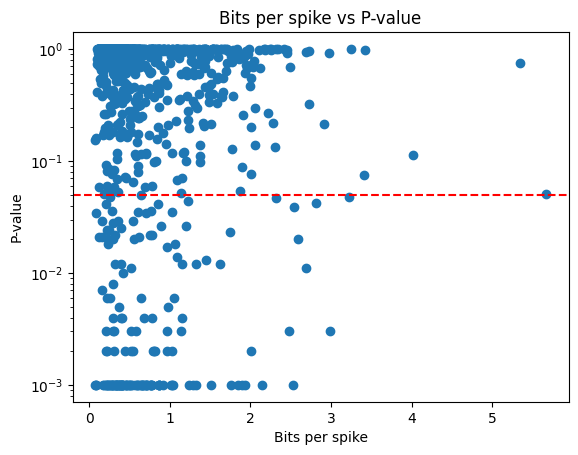

In [ ]:
spatial_info_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Plot bits per spike against P-value
# Add small constant to avoid log(0)
spatial_info_all['p_value'] = spatial_info_all['p_value'] + 1e-3
plt.scatter(spatial_info_all['bits_per_spike'], spatial_info_all['p_value'])
plt.xlabel('Bits per spike')
plt.ylabel('P-value')
plt.title('Bits per spike vs P-value')
plt.yscale('log')
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.show()

In [ ]:
# from scipy.io import savemat

# rate_maps_open_field_1 = rate_maps_all.to_dict()['open-field_1']
# rate_maps_open_field_2 = rate_maps_all.to_dict()['open-field_2']
# rate_maps_t_maze_1 = rate_maps_all.to_dict()['t-maze_1']
# rate_maps_t_maze_2 = rate_maps_all.to_dict()['t-maze_2']
# occupancy_maps_open_field_1 = occupancy_maps_all.to_dict()['open-field_1']
# occupancy_maps_open_field_2 = occupancy_maps_all.to_dict()['open-field_2']
# occupancy_maps_t_maze_1 = occupancy_maps_all.to_dict()['t-maze_1']
# occupancy_maps_t_maze_2 = occupancy_maps_all.to_dict()['t-maze_2']

# maps_list = [rate_maps_open_field_1, rate_maps_open_field_2, rate_maps_t_maze_1, rate_maps_t_maze_2,
#              occupancy_maps_open_field_1, occupancy_maps_open_field_2, occupancy_maps_t_maze_1, occupancy_maps_t_maze_2]

# # add letter to each value in dict keys to make them valid matlab field names
# for m in maps_list[0:4]:
#     keys = list(m.keys())
#     for k in keys:
#         m['a' + k] = m.pop(k)
# for m in maps_list[4:8]:
#     keys = list(m.keys())
#     for k in keys:
#         m['b' + k] = m.pop(k)

# savemat('rate_maps_open-field_1.mat', maps_list[0])
# savemat('rate_maps_open-field_2.mat', maps_list[1])
# savemat('rate_maps_t-maze_1.mat', maps_list[2])
# savemat('rate_maps_t-maze_2.mat', maps_list[3])
# savemat('occupancy_maps_open-field_1.mat', maps_list[4])
# savemat('occupancy_maps_open-field_2.mat', maps_list[5])
# savemat('occupancy_maps_t-maze_1.mat', maps_list[6])
# savemat('occupancy_maps_t-maze_2.mat', maps_list[7])

## Spatial Information & Stats

In [ ]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set age bins
age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')
spatial_info_df = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/spatial_info_all.pkl')

# Format spatial info dataframe
spatial_info_df.dropna(inplace = True)
spatial_info_df.reset_index(inplace = True)
spatial_info_df = spatial_info_df.rename(columns = {'index': 'cell_id'})
spatial_info_df['trial_type'] = spatial_info_df['cell_id'].apply(lambda x: x.split('_')[-3])
spatial_info_df['age'] = spatial_info_df['age'].astype(int)

# Group by age bin
spatial_info_df['age_bin'] = pd.cut(spatial_info_df['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_info_df['age_bin'] = pd.Categorical(spatial_info_df['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of bits_per_spike and bits_per_sec
spatial_info_df_stats = spatial_info_df.groupby('age_bin').agg({'bits_per_spike': ['mean', 'std'], 'bits_per_sec': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and bits per spike
anova_bits_per_spike = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_spike'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_spike'])
print(f'ANOVA for bits per spike: {anova_bits_per_spike}')

# Perform ANOVA on age bin and bits per sec
anova_bits_per_sec = stats.f_oneway(spatial_info_df[spatial_info_df['age_bin'] == '22-26']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '27-29']['bits_per_sec'],
                       spatial_info_df[spatial_info_df['age_bin'] == '30-35']['bits_per_sec'])
print(f'ANOVA for bits per sec: {anova_bits_per_sec}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_info_df['age_bin'] = spatial_info_df['age_bin'].replace(age_bin_mapping)

if anova_bits_per_spike[1] < 0.05:
    # Perform Tukey HSD test for bits per spike
    tukey_bits_per_spike = pairwise_tukeyhsd(spatial_info_df['bits_per_spike'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per spike: {tukey_bits_per_spike}')
else:
    print('ANOVA for bits per spike not significant, skipping Tukey HSD test')

# if p < 0.05, perform Tukey HSD test
if anova_bits_per_sec[1] < 0.05:
    # Perform Tukey HSD test for bits per sec
    tukey_bits_per_sec = pairwise_tukeyhsd(spatial_info_df['bits_per_sec'].astype(float), spatial_info_df['age_bin'])
    print(f'Tukey HSD for bits per sec: {tukey_bits_per_sec}')
else:
    print('ANOVA for bits per sec not significant, skipping Tukey HSD test')

# Plot bits_per_spike and bits_per_sec for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_spike']['mean'], yerr = spatial_info_df_stats['bits_per_spike']['std'], fmt = 'o')
axes[0].set_title('Bits per spike')
axes[0].set_xlabel('Age bin')
axes[0].set_ylabel('Bits per spike')
axes[0].set_ylim(0, 1.5)

axes[1].errorbar(x = spatial_info_df_stats['age_bin'], y = spatial_info_df_stats['bits_per_sec']['mean'], yerr = spatial_info_df_stats['bits_per_sec']['std'], fmt = 'o')
axes[1].set_title('Bits per second')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Bits per second')
axes[1].set_ylim(0, 3)


## Spatial Correlation & Stats

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from spatial_correlation import spatial_correlation
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled rate map data
rate_maps_all = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/rate_maps_all.pkl')


# Calculate spatial correlation for each cluster across both trial types
for trial_type in ['open-field', 't-maze']:
    rate_maps_correlation = rate_maps_all[[f'{trial_type}_1', f'{trial_type}_2']].dropna()

    spatial_correlations = spatial_correlation(rate_maps_correlation[f'{trial_type}_1'].to_list(), rate_maps_correlation[f'{trial_type}_2'].to_list())

    rate_maps_all.loc[rate_maps_correlation.index, f'spatial_correlation_{trial_type}'] = spatial_correlations

rate_maps_all

# Keep only age and spatial correlation columns
spatial_correlations = rate_maps_all[['age', 'spatial_correlation_open-field', 'spatial_correlation_t-maze']].dropna().copy()
# Convert age to int
spatial_correlations['age'] = spatial_correlations['age'].astype(int)

# Group by age bin
spatial_correlations['age_bin'] = pd.cut(spatial_correlations['age'], bins = [22, 26, 29, 35], labels = ['22-26', '27-29', '30-35'])
# Convert 'age_bin' column to categorical data type
spatial_correlations['age_bin'] = pd.Categorical(spatial_correlations['age_bin'], categories=['22-26', '27-29', '30-35'], ordered=True)

# Calculate mean and std of spatial info correlations
spatial_correlations_stats = spatial_correlations.groupby('age_bin').agg({'spatial_correlation_open-field': ['mean', 'std'], 'spatial_correlation_t-maze': ['mean', 'std']}).reset_index()

# Perform ANOVA on age bin and open field spatial correlation
anova_open_field = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_open-field'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_open-field'])
print(f'ANOVA for spatial_correlation_open-field: {anova_open_field}')

# Perform ANOVA on age bin and t-maze spatial correlation
anova_tmaze = stats.f_oneway(spatial_correlations[spatial_correlations['age_bin'] == '22-26']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '27-29']['spatial_correlation_t-maze'],
                       spatial_correlations[spatial_correlations['age_bin'] == '30-35']['spatial_correlation_t-maze'])
print(f'ANOVA for spatial_correlation_t-maze: {anova_tmaze}')

# Replace string age bins with integers
age_bin_mapping = {'22-26': 1, '27-29': 2, '30-35': 3}
spatial_correlations['age_bin'] = spatial_correlations['age_bin'].replace(age_bin_mapping)

# if p < 0.05, perform Tukey HSD test
if anova_open_field[1] < 0.05:
    print('ANOVA significant, performing Tukey HSD test')
    # Perform Tukey HSD test for open field spatial correlation
    tukey_open_field = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_open-field'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for spatial_correlation_open-field: {tukey_open_field}')
else:
    print('ANOVA for open field not significant, skipping Tukey HSD test')

if anova_tmaze[1] < 0.05:
    # Perform Tukey HSD test for t-maze spatial correlation
    tukey_tmaze = pairwise_tukeyhsd(spatial_correlations['spatial_correlation_t-maze'], spatial_correlations['age_bin'])
    print(f'Tukey HSD for bits spatial_correlation_t-maze: {tukey_tmaze}')
else:
    print('ANOVA for T-maze not significant, skipping Tukey HSD test')

# Plot spatial correlation for open field and t-maze for each age bin
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_open-field']['mean'], yerr = spatial_correlations_stats['spatial_correlation_open-field']['std'], fmt = 'o')
axes[0].set_title('Spatial Correlation Open Field')
axes[0].set_xlabel('Age bin')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Spatial Correlation')

axes[1].errorbar(x = spatial_correlations_stats['age_bin'], y = spatial_correlations_stats['spatial_correlation_t-maze']['mean'], yerr = spatial_correlations_stats['spatial_correlation_t-maze']['std'], fmt = 'o')
axes[1].set_title('Spatial Correlation T-Maze')
axes[1].set_xlabel('Age bin')
axes[1].set_ylabel('Spatial Correlation')
axes[1].set_ylim(0, 1)

In [ ]:
obj.pos_data[0]['header']